In [1]:
import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

# Adapted from https://github.com/A-LinCui/Adversarial_Patch_Attack

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std


norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
weights = ResNet50_Weights.DEFAULT

model = nn.Sequential(
    norm_layer,
    resnet50(weights=weights))


model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)

model = model.eval()

torch.Size([3, 2501, 2501]) torch.Size([1, 3, 224, 224])


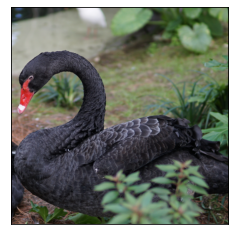

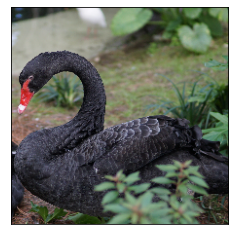

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


transform = T.Compose([
    T.Resize((224, 224)),
    T.Normalize(mean=[0, 0, 0], std=[255.0, 255.0, 255.0]),    
])

        
img = read_image('images/black_swan.jpeg')
#img = read_image('images/macaw.jpg')
show([img])
batch = transform(img.float()).unsqueeze(0)
print(img.shape,batch.shape)
show(batch)

In [3]:
batch = batch.to(device)
prediction = model(batch).squeeze(0).softmax(0)

class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")
print("Top-K labels:",prediction.topk(5)[1].cpu().numpy())


black swan: 47.5%
Top-K labels: [100 146  99  22  80]


In [6]:
import numpy as np
from torch.autograd import Variable
import math

def patch_initialization(patch_type='rectangle', image_size=(3, 224, 224), noise_percentage=0.03):
    if patch_type == 'rectangle':
        
        print()
        total = image_size[1]*image_size[2]
        noiseSize = total*noise_percentage
        mask_length = round(math.sqrt(noiseSize))
        print(mask_length)
        #mask_length = int((noise_percentage * image_size[1] * image_size[2])**0.45)
        patch = np.random.rand(image_size[0], mask_length, mask_length)
    return patch


# Generate the mask and apply the patch
# TODO: Add circle type
def mask_generation(mask_type='rectangle', patch=None, image_size=(3, 224, 224)):
    applied_patch = np.zeros(image_size)
    if mask_type == 'rectangle':
        # patch rotation
        rotation_angle = np.random.choice(4)
        for i in range(patch.shape[0]):
            patch[i] = np.rot90(patch[i], rotation_angle)  # The actual rotation angle is rotation_angle * 90
        # patch location
        x_location, y_location = np.random.randint(low=0, high=image_size[1]-patch.shape[1]), np.random.randint(low=0, high=image_size[2]-patch.shape[2])
        for i in range(patch.shape[0]):
            applied_patch[:, x_location:x_location + patch.shape[1], y_location:y_location + patch.shape[2]] = patch
    mask = applied_patch.copy()
    mask[mask != 0] = 1.0
    return applied_patch, mask, x_location, y_location



def patch_attack(image, applied_patch, mask, target, probability_threshold, model, lr=1, max_iteration=100):
    model.eval()
    applied_patch = torch.from_numpy(applied_patch)
    mask = torch.from_numpy(mask)
    target_probability, count = 0, 0
    perturbated_image = torch.mul(mask.type(torch.FloatTensor), applied_patch.type(torch.FloatTensor)) + torch.mul((1 - mask.type(torch.FloatTensor)), image.type(torch.FloatTensor))
    
    output = model(image)
    #print("Target: ",target, "Argmax: ",torch.argmax(output))
    argMaxLabel = torch.argmax(output)
    
    while target_probability < probability_threshold and count < max_iteration:
        count += 1
        # Optimize the patch
        perturbated_image = Variable(perturbated_image.data, requires_grad=True)
        per_image = perturbated_image
        per_image = per_image.cuda()
        output = model(per_image)
        target_log_softmax = torch.nn.functional.log_softmax(output, dim=1)[0][target]
        target_log_softmax.backward()        
        patch_grad_target = perturbated_image.grad.clone().cpu()
        perturbated_image.grad.data.zero_()
        
        output = model(per_image)
        print("Itr:",count,"Target: ",target, "Argmax: ",torch.argmax(output),torch.max(output.squeeze(0).softmax(0)))
        argmax_log_softmax = torch.nn.functional.log_softmax(output, dim=1)[0][argMaxLabel]
        argmax_log_softmax.backward()
        argmax_grad_target = perturbated_image.grad.clone().cpu()
        perturbated_image.grad.data.zero_()
        
        
        applied_patch = lr * (patch_grad_target-argmax_grad_target) + applied_patch.type(torch.FloatTensor)
        
        #print(applied_patch.max(),applied_patch.min())
        applied_patch = torch.clamp(applied_patch, min=-1, max=1)
        
        
        # Test the patch
        perturbated_image = torch.mul(mask.type(torch.FloatTensor), applied_patch.type(torch.FloatTensor)) + torch.mul((1-mask.type(torch.FloatTensor)), image.type(torch.FloatTensor))
        perturbated_image = torch.clamp(perturbated_image, min=0, max=1)
        perturbated_image = perturbated_image.cuda()
        
        print("Perturbated Image",perturbated_image.max(),perturbated_image.min())
        output = model(perturbated_image)
        target_probability = torch.nn.functional.softmax(output, dim=1).data[0][target]
    perturbated_image = perturbated_image.cpu().numpy()
    applied_patch = applied_patch.cpu().numpy()
    return perturbated_image, applied_patch



target = 859
probability_threshold = 0.5
noise_percentage = 0.02
lr = 0.2
max_iteration=10000
patch_type = 'rectangle'
patch = patch_initialization(patch_type, image_size=(3, 224, 224), noise_percentage=noise_percentage)




print('The shape of the patch is', patch.shape)
applied_patch, mask, x_location, y_location = mask_generation(patch_type, patch, image_size=(3, 224, 224))
print(patch.shape,applied_patch.shape)
perturbated_image, applied_patch = patch_attack(batch, applied_patch, mask, target, probability_threshold, model, lr, max_iteration)



32
The shape of the patch is (3, 32, 32)
(3, 32, 32) (3, 224, 224)
Itr: 1 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.4919, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 2 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.4746, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 3 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.4668, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 4 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.4620, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 5 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.4573, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='c

Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 50 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.4629, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 51 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.4508, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 52 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.4486, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 53 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.4636, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 54 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.4546, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0.

Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 95 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.4099, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 96 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.4136, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 97 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.4173, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 98 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.4050, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 99 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.4268, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0.

Itr: 139 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3865, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 140 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.4052, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 141 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3747, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 142 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3865, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 143 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.4085, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 144 Target:  859 Argmax:  tensor(100, device=

Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 184 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3694, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 185 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3807, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 186 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3796, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 187 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3673, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 188 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3836, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tens

Itr: 227 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3466, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 228 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3355, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 229 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3486, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 230 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3318, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 231 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3460, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 232 Target:  859 Argmax:  tensor(100, device=

Itr: 275 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3305, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 276 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3319, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 277 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3210, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 278 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3299, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 279 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3150, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 280 Target:  859 Argmax:  tensor(100, device=

Itr: 324 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3102, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 325 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3233, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 326 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3305, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 327 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3387, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 328 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3060, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 329 Target:  859 Argmax:  tensor(100, device=

Itr: 368 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3139, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 369 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3006, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 370 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3087, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 371 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3101, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 372 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3138, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 373 Target:  859 Argmax:  tensor(100, device=

Itr: 412 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3064, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 413 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.2989, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 414 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3061, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 415 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3192, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 416 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3176, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 417 Target:  859 Argmax:  tensor(859, device=

Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 458 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.2971, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 459 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.3032, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 460 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3305, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 461 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3194, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 462 Target:  859 Argmax:  tensor(100, device='cuda:0') tensor(0.2989, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tens

Itr: 501 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3124, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 502 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3133, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 503 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3300, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 504 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3275, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 505 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3209, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 506 Target:  859 Argmax:  tensor(859, device=

Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 547 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3584, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 548 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3550, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 549 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3471, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 550 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3222, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 551 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3148, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tens

Itr: 590 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3546, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 591 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3577, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 592 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3303, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 593 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3608, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 594 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3570, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 595 Target:  859 Argmax:  tensor(859, device=

Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 639 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3687, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 640 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3645, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 641 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3724, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 642 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3745, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 643 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3635, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tens

Itr: 687 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3775, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 688 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3691, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 689 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3680, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 690 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3795, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 691 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3565, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 692 Target:  859 Argmax:  tensor(859, device=

Itr: 736 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3800, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 737 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3852, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 738 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3837, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 739 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3745, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 740 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3858, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 741 Target:  859 Argmax:  tensor(859, device=

Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 785 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3746, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 786 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3969, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 787 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3948, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 788 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3850, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 789 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3941, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tens

Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 834 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3932, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 835 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3969, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 836 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3861, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 837 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3824, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 838 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3720, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tens

Itr: 882 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3999, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 883 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4128, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 884 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3846, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 885 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3716, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 886 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3706, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 887 Target:  859 Argmax:  tensor(859, device=

Itr: 926 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3960, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 927 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3678, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 928 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3843, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 929 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3797, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 930 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3914, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 931 Target:  859 Argmax:  tensor(859, device=

Itr: 971 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4094, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 972 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4125, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 973 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4169, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 974 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4179, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 975 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4103, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 976 Target:  859 Argmax:  tensor(859, device=

Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1017 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4174, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1018 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4142, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1019 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3906, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1020 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4057, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1021 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3649, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0')

Itr: 1062 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4261, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1063 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4143, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1064 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4219, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1065 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3934, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1066 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4143, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1067 Target:  859 Argmax:  tensor(859, d

Itr: 1107 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4089, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1108 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4120, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1109 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4055, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1110 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4125, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1111 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4061, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1112 Target:  859 Argmax:  tensor(859, d

Itr: 1156 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4205, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1157 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4078, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1158 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4227, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1159 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4082, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1160 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4200, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1161 Target:  859 Argmax:  tensor(859, d

Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1202 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4064, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1203 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4161, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1204 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4263, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1205 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4012, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1206 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4279, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0')

Itr: 1247 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4395, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1248 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4329, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1249 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4408, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1250 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4234, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1251 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4140, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1252 Target:  859 Argmax:  tensor(859, d

Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1293 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4520, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1294 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4560, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1295 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4529, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1296 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4564, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1297 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4403, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0')

Itr: 1338 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4575, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1339 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4441, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1340 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4384, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1341 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3921, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1342 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4304, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1343 Target:  859 Argmax:  tensor(859, d

Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1384 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4405, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1385 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4220, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1386 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4403, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1387 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4396, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1388 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4321, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0')

Itr: 1429 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.3819, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1430 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4160, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1431 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4157, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1432 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4431, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1433 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4475, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1434 Target:  859 Argmax:  tensor(859, d

Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1475 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4436, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1476 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4407, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1477 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4292, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1478 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4395, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1479 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4040, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0')

Itr: 1520 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4539, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1521 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4654, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1522 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4636, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1523 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4760, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1524 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4707, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1525 Target:  859 Argmax:  tensor(859, d

Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1566 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4661, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1567 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4657, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1568 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4768, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1569 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4776, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1570 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4840, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0')

Itr: 1611 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4798, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1612 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4796, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1613 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4682, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1614 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4412, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1615 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4735, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1616 Target:  859 Argmax:  tensor(859, d

Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1657 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4864, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1658 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4922, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1659 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4939, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1660 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4900, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Itr: 1661 Target:  859 Argmax:  tensor(859, device='cuda:0') tensor(0.4757, device='cuda:0', grad_fn=<MaxBackward1>)
Perturbated Image tensor(1., device='cuda:0')

In [7]:
prediction = model(torch.from_numpy(perturbated_image)).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]


Attacked Label: toaster 50.0%
1.0 0.0
tensor(0.9925, device='cuda:0') tensor(6.1291e-05, device='cuda:0')


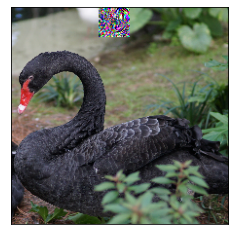

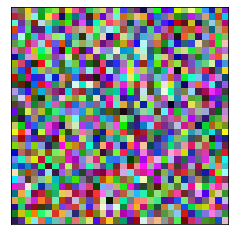

In [8]:
print("Attacked Label: "f"{category_name} {100 * score:.1f}%")
show(torch.from_numpy(perturbated_image))
show([torch.from_numpy(patch)])
print(perturbated_image.max(),perturbated_image.min())
print(batch[0].max(),batch[0].min())